--- Simple EDA Plots ---


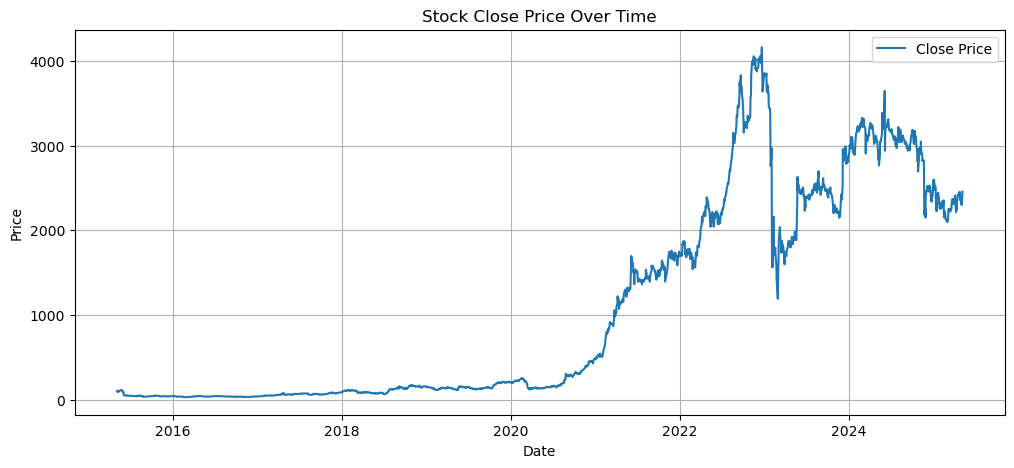

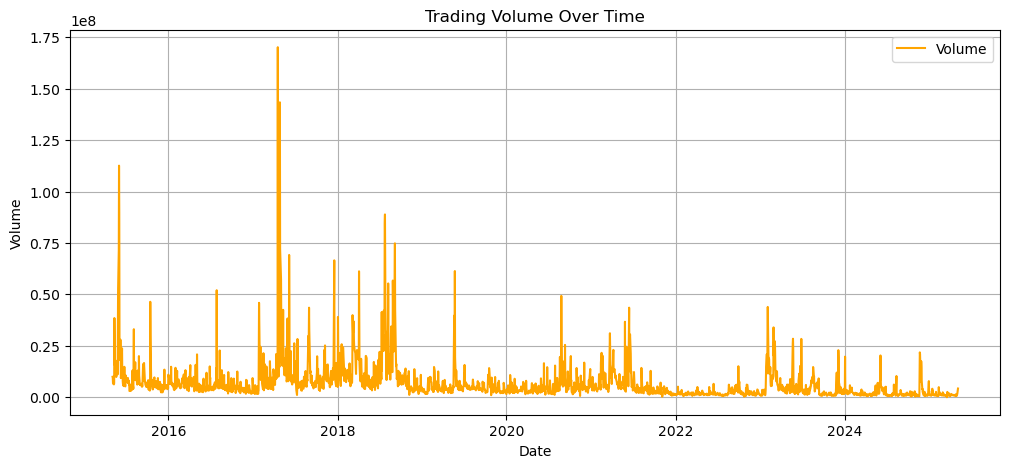

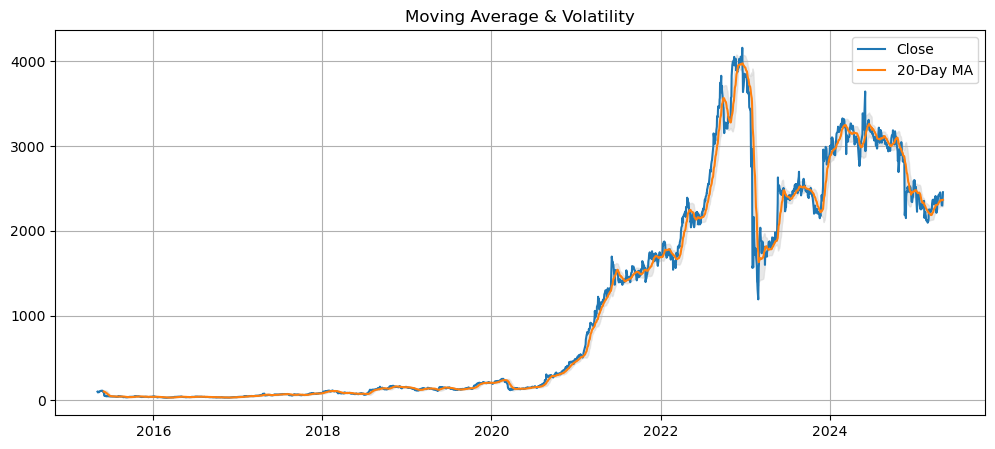

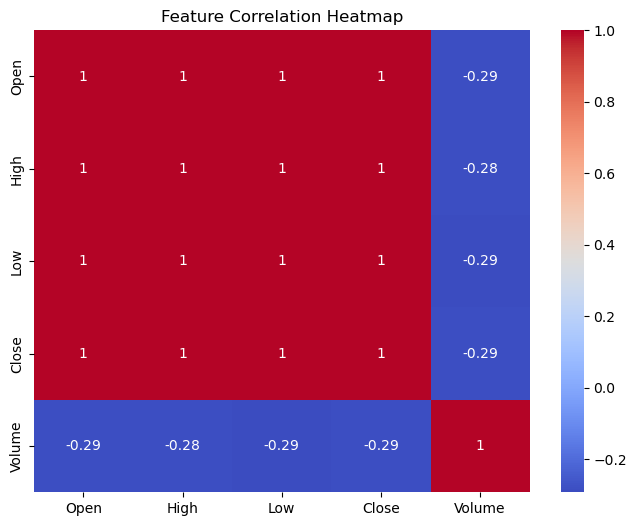


--- Candlestick Chart ---



--- Anomaly Detection ---
Number of Isolation Forest Anomalies: 700


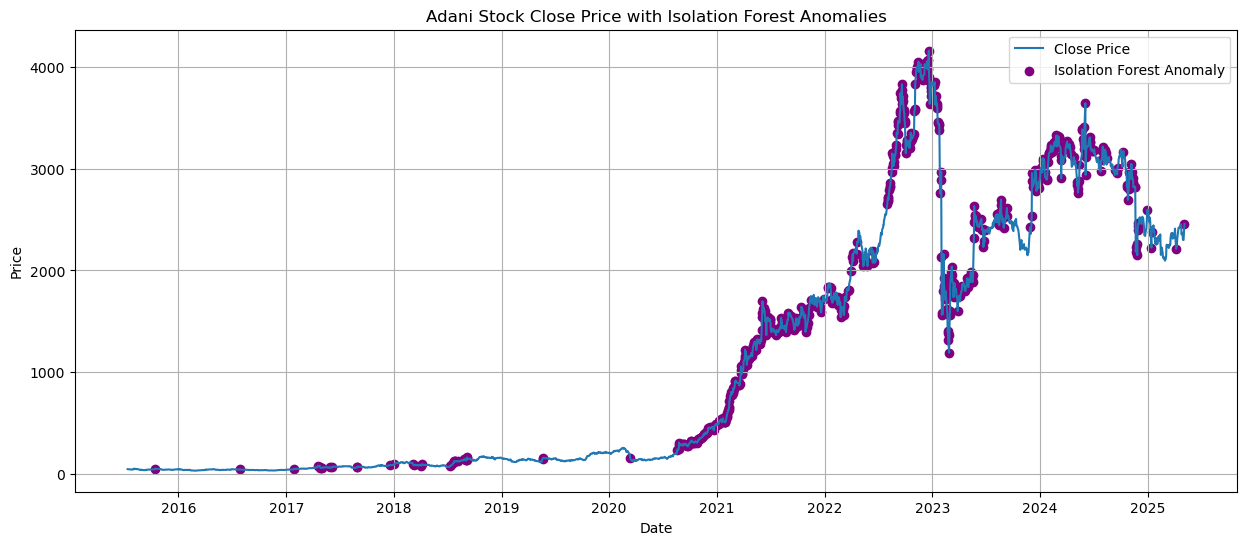

Number of Local Outlier Factor Anomalies: 166


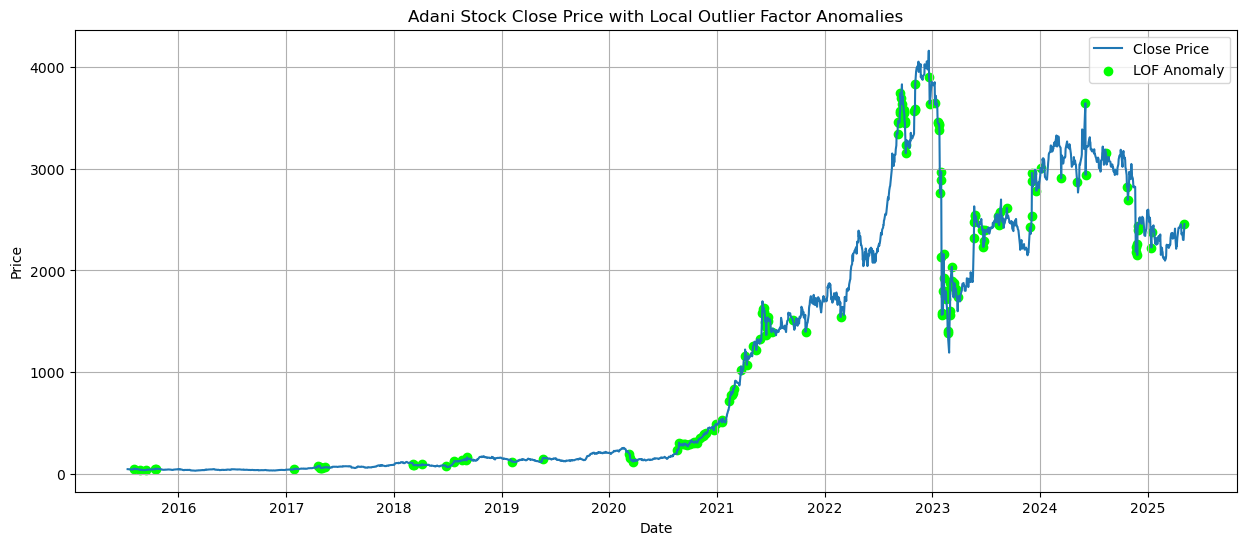

Number of DBSCAN Anomalies: 194


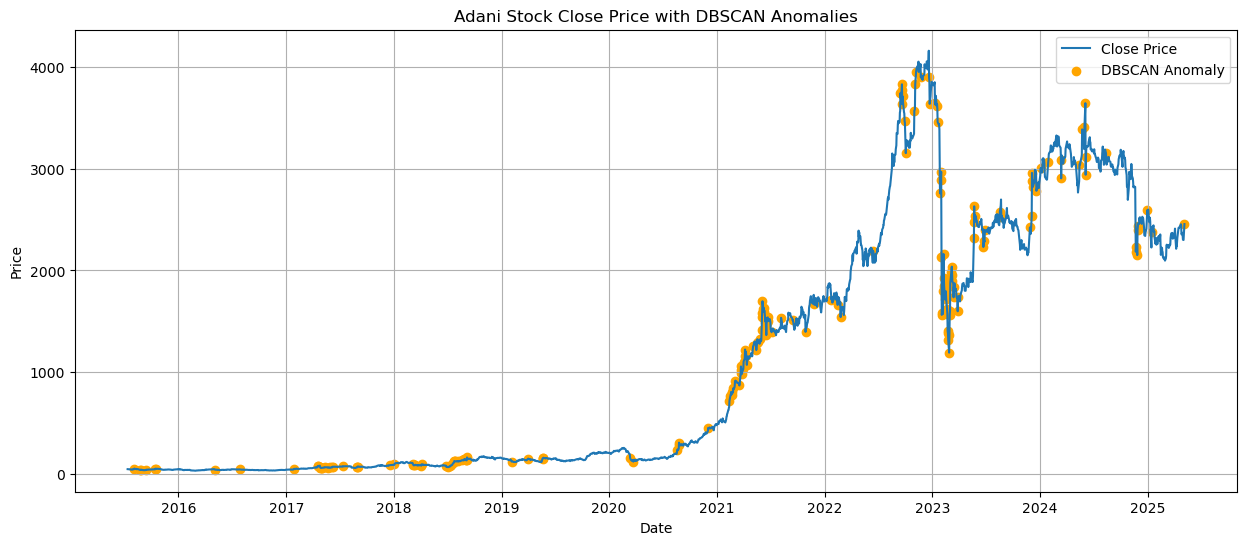


--- Combined Anomaly Results (Row by Row) ---
Number of Combined Anomalies (IF OR LOF OR DBSCAN): 727

Rows where at least one anomaly was detected:
                                 Close    Volume    Return  IF_Anomaly  \
Date                                                                     
2015-08-04 00:00:00+05:30    49.843029  19284731  0.113797       False   
2015-08-24 00:00:00+05:30    37.652721  10248837 -0.130938       False   
2015-08-27 00:00:00+05:30    42.111946  19986363  0.108333       False   
2015-09-14 00:00:00+05:30    40.687111  16092993  0.110951       False   
2015-10-15 00:00:00+05:30    51.056782  46389867  0.140920        True   
...                                ...       ...       ...         ...   
2024-12-30 00:00:00+05:30  2592.350098   7825097  0.075686        True   
2025-01-13 00:00:00+05:30  2225.149902   1559903 -0.062858        True   
2025-01-14 00:00:00+05:30  2380.550049   4120705  0.069838        True   
2025-04-07 00:00:00+05:30  2212.6999

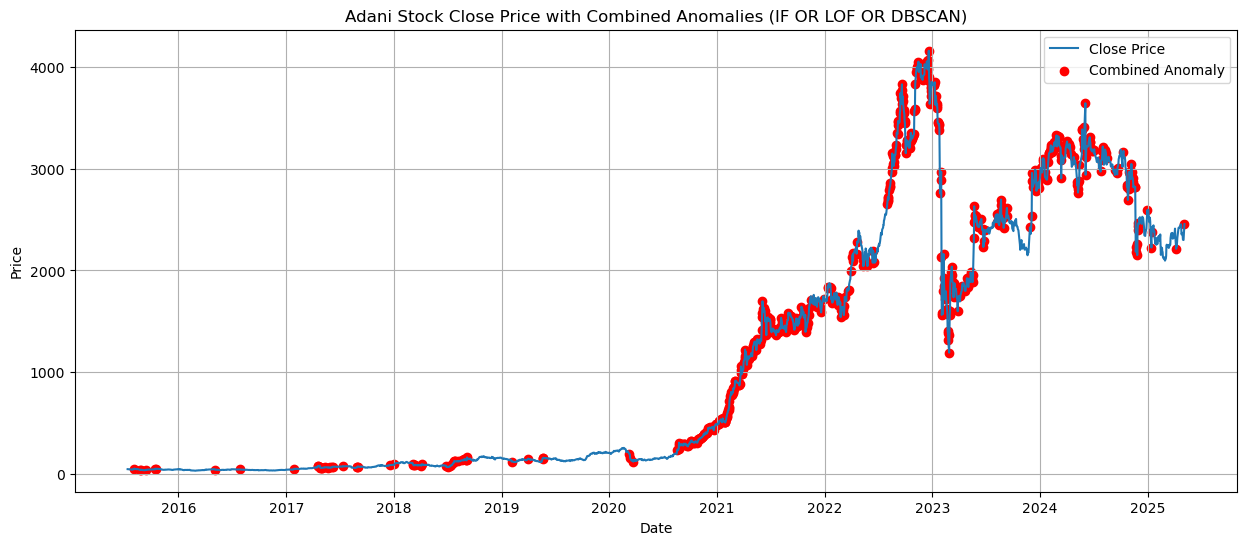


Number of Combined Anomalies (IF AND LOF AND DBSCAN): 100

Rows where all three anomalies were detected:
                                 Close     Volume    Return  IF_Anomaly  \
Date                                                                      
2015-10-15 00:00:00+05:30    51.056782   46389867  0.140920        True   
2017-01-27 00:00:00+05:30    49.395317   45884559  0.157500        True   
2017-04-18 00:00:00+05:30    77.293549  170150231  0.174706        True   
2017-04-26 00:00:00+05:30    63.237743   82181128 -0.209403        True   
2017-04-27 00:00:00+05:30    60.890671  143366815 -0.037115        True   
...                                ...        ...       ...         ...   
2024-11-26 00:00:00+05:30  2150.500000    7723187 -0.047398        True   
2024-11-27 00:00:00+05:30  2397.800049   17502156  0.114997        True   
2024-11-28 00:00:00+05:30  2437.100098   14445549  0.016390        True   
2025-01-14 00:00:00+05:30  2380.550049    4120705  0.069838        Tr

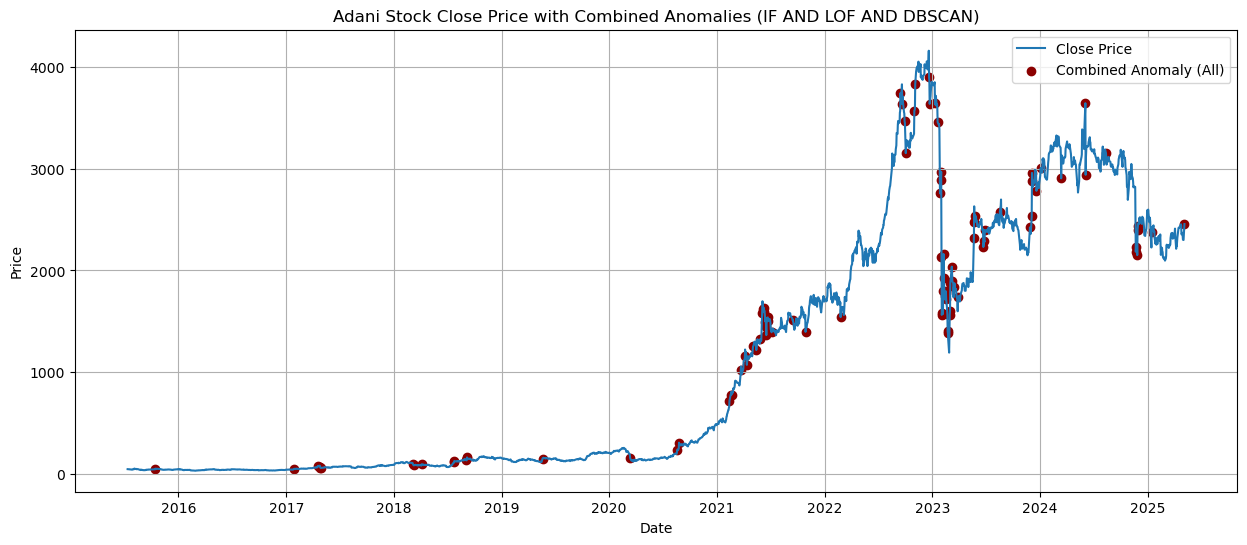

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN

# Load data
df = pd.read_csv("adani_stock_data_with_indicators.csv")  # Replace with your actual file path

# ----------------------------
# 1. Data Cleaning
# ----------------------------
# Convert the 'Date' column to datetime objects. This is essential for time series analysis.
df['Date'] = pd.to_datetime(df['Date'])
# Sort the DataFrame by date to ensure chronological order, which is crucial for time series.
df = df.sort_values('Date').reset_index(drop=True)
# Remove any duplicate rows to avoid skewing the analysis.
df = df.drop_duplicates()
# Set the 'Date' column as the index of the DataFrame. This makes it easier to work with time series data.
df.set_index('Date', inplace=True)

# ----------------------------
# 2. Simple EDA (Exploratory Data Analysis)
# ----------------------------
print("--- Simple EDA Plots ---")

# Plot the closing price of the stock over time to see the overall trend.
plt.figure(figsize=(12, 5))
plt.plot(df['Close'], label='Close Price')
plt.title('Stock Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Plot the trading volume over time to identify periods of high or low activity.
plt.figure(figsize=(12, 5))
plt.plot(df['Volume'], color='orange', label='Volume')
plt.title('Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.show()

# Calculate the 20-day rolling mean and standard deviation of the closing price.
# The rolling mean smooths out short-term fluctuations, and the rolling standard deviation
# provides a measure of volatility.
df['RollingMean'] = df['Close'].rolling(window=20).mean()
df['RollingStd'] = df['Close'].rolling(window=20).std()

# Plot the closing price along with the 20-day moving average and shaded areas representing
# one standard deviation above and below the moving average (a simple way to visualize volatility).
plt.figure(figsize=(12, 5))
plt.plot(df['Close'], label='Close')
plt.plot(df['RollingMean'], label='20-Day MA')
plt.fill_between(df.index, df['RollingMean'] - df['RollingStd'],
                 df['RollingMean'] + df['RollingStd'], color='lightgray', alpha=0.5)
plt.title('Moving Average & Volatility')
plt.legend()
plt.grid(True)
plt.show()

# Create a heatmap to visualize the correlation between different numerical features.
# This helps understand the linear relationships between 'Open', 'High', 'Low', 'Close', and 'Volume'.
plt.figure(figsize=(8, 6))
sns.heatmap(df[['Open', 'High', 'Low', 'Close', 'Volume']].corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

# ----------------------------
# 3. Candlestick Chart
# ----------------------------
print("\n--- Candlestick Chart ---")
# Create an interactive candlestick chart using Plotly.
# Candlestick charts provide a detailed view of the price action for each trading day.
fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'])])

fig.update_layout(title='Adani Stock Candlestick Chart',
                  xaxis_title='Date',
                  yaxis_title='Price')
fig.show()

# ----------------------------
# 4. Preprocessing
# ----------------------------
# Calculate the percentage change in the closing price from the previous day (daily returns).
df['Return'] = df['Close'].pct_change()
# Calculate the 10-day and 50-day Simple Moving Averages, which are common technical indicators.
df['SMA_10'] = df['Close'].rolling(window=10).mean()
df['SMA_50'] = df['Close'].rolling(window=50).mean()

# Calculate the Relative Strength Index (RSI), a momentum indicator that measures the magnitude
# of recent price changes to evaluate overbought or oversold conditions in the price of a stock.
delta = df['Close'].diff()
gain = np.where(delta > 0, delta, 0)
loss = np.where(delta < 0, -delta, 0)
roll_up = pd.Series(gain).rolling(14).mean()
roll_down = pd.Series(loss).rolling(14).mean()
epsilon = 1e-10  # Small value to avoid division by zero
df['RSI'] = 100 - (100 / (1 + (gain / (loss + epsilon))))

# Remove rows with NaN values that were introduced by the rolling calculations and percentage change.
df = df.dropna()

# Select the features that will be used for anomaly detection.
features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Return', 'SMA_10', 'SMA_50', 'RSI']
# Initialize the StandardScaler to standardize the features by removing the mean and scaling to unit variance.
scaler = StandardScaler()
# Fit the scaler to the selected features and transform the data into a scaled format.
df_scaled = pd.DataFrame(scaler.fit_transform(df[features]), columns=features, index=df.index)

# Create a copy of the scaled DataFrame for use in the anomaly detection models.
df_preprocessed = df_scaled.copy()

# ----------------------------
# 5. Anomaly Detection Models
# ----------------------------
print("\n--- Anomaly Detection ---")

# --- Isolation Forest ---
# Initialize the Isolation Forest model.
# n_estimators: The number of trees in the forest.
# contamination: The expected proportion of outliers in the dataset ('auto' lets the algorithm estimate it).
# random_state: For reproducibility.
iso_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=42)
# Fit the model to the preprocessed data and get the anomaly predictions (-1 for anomaly, 1 for inlier).
iso_predictions = iso_forest.fit_predict(df_preprocessed)
# Create a boolean column in the original DataFrame indicating whether a point is an anomaly.
df['IF_Anomaly'] = iso_predictions == -1
if_anomalies_count = df['IF_Anomaly'].sum()
print(f"Number of Isolation Forest Anomalies: {if_anomalies_count}")

# Plot the close price with the detected Isolation Forest anomalies highlighted.
plt.figure(figsize=(15, 6))
plt.plot(df['Close'], label='Close Price')
plt.scatter(df[df['IF_Anomaly']].index, df[df['IF_Anomaly']]['Close'], color='purple', label='Isolation Forest Anomaly')
plt.title('Adani Stock Close Price with Isolation Forest Anomalies')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# --- Local Outlier Factor (LOF) ---
# Initialize the Local Outlier Factor model.
# n_neighbors: The number of neighbors to consider for local density estimation.
# contamination: The expected proportion of outliers.
lof = LocalOutlierFactor(n_neighbors=20, contamination='auto')
# Fit the model and get the anomaly predictions (-1 for anomaly, 1 for inlier).
lof_predictions = lof.fit_predict(df_preprocessed)
# Create a boolean column in the original DataFrame indicating LOF anomalies.
df['LOF_Anomaly'] = lof_predictions == -1
lof_anomalies_count = df['LOF_Anomaly'].sum()
print(f"Number of Local Outlier Factor Anomalies: {lof_anomalies_count}")

# Plot the close price with the detected LOF anomalies.
plt.figure(figsize=(15, 6))
plt.plot(df['Close'], label='Close Price')
plt.scatter(df[df['LOF_Anomaly']].index, df[df['LOF_Anomaly']]['Close'], color='lime', label='LOF Anomaly')
plt.title('Adani Stock Close Price with Local Outlier Factor Anomalies')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# --- DBSCAN ---
# Initialize the DBSCAN model.
# eps: The maximum distance between two samples for one to be considered as in the neighborhood of the other.
# min_samples: The number of samples in a neighborhood for a point to be considered a core point.
# Note: These parameters often require tuning based on the data characteristics.
dbscan = DBSCAN(eps=0.5, min_samples=5)
# Fit the model and get the cluster assignments (-1 indicates noise points, which are considered anomalies).
dbscan_predictions = dbscan.fit_predict(df_preprocessed)
# Create a boolean column indicating DBSCAN anomalies (noise points).
df['DBSCAN_Anomaly'] = dbscan_predictions == -1
dbscan_anomalies_count = df['DBSCAN_Anomaly'].sum()
print(f"Number of DBSCAN Anomalies: {dbscan_anomalies_count}")

# Plot the close price with the detected DBSCAN anomalies.
plt.figure(figsize=(15, 6))
plt.plot(df['Close'], label='Close Price')
plt.scatter(df[df['DBSCAN_Anomaly']].index, df[df['DBSCAN_Anomaly']]['Close'], color='orange', label='DBSCAN Anomaly')
plt.title('Adani Stock Close Price with DBSCAN Anomalies')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# ----------------------------
# 6. Combining Anomaly Results and Displaying Row by Row
# ----------------------------
print("\n--- Combined Anomaly Results (Row by Row) ---")

# Combine anomalies: A data point is considered an anomaly if flagged by at least one method (OR condition).
df['Combined_Anomaly'] = df['IF_Anomaly'] | df['LOF_Anomaly'] | df['DBSCAN_Anomaly']
combined_anomalies_count = df['Combined_Anomaly'].sum()
print(f"Number of Combined Anomalies (IF OR LOF OR DBSCAN): {combined_anomalies_count}")

# Iterate through the DataFrame and print rows where at least one anomaly flag is True.
combined_anomalies_df = df[df['Combined_Anomaly']]
print("\nRows where at least one anomaly was detected:")
print(combined_anomalies_df[['Close', 'Volume', 'Return', 'IF_Anomaly', 'LOF_Anomaly', 'DBSCAN_Anomaly', 'Combined_Anomaly']])

# Plot the close price with the combined anomalies (OR condition).
plt.figure(figsize=(15, 6))
plt.plot(df['Close'], label='Close Price')
plt.scatter(df[df['Combined_Anomaly']].index, df[df['Combined_Anomaly']]['Close'], color='red', label='Combined Anomaly')
plt.title('Adani Stock Close Price with Combined Anomalies (IF OR LOF OR DBSCAN)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Optional: Combine anomalies: A data point is considered an anomaly only if flagged by all three methods (AND condition).
df['Combined_Anomaly_All'] = df['IF_Anomaly'] & df['LOF_Anomaly'] & df['DBSCAN_Anomaly']
combined_anomalies_all_count = df['Combined_Anomaly_All'].sum()
print(f"\nNumber of Combined Anomalies (IF AND LOF AND DBSCAN): {combined_anomalies_all_count}")

# Iterate through the DataFrame and print rows where all anomaly flags are True.
combined_anomalies_all_df = df[df['Combined_Anomaly_All']]
print("\nRows where all three anomalies were detected:")
print(combined_anomalies_all_df[['Close', 'Volume', 'Return', 'IF_Anomaly', 'LOF_Anomaly', 'DBSCAN_Anomaly', 'Combined_Anomaly_All']])

# Plot the close price with the combined anomalies (AND condition).
plt.figure(figsize=(15, 6))
plt.plot(df['Close'], label='Close Price')
plt.scatter(df[df['Combined_Anomaly_All']].index, df[df['Combined_Anomaly_All']]['Close'], color='darkred', label='Combined Anomaly (All)')
plt.title('Adani Stock Close Price with Combined Anomalies (IF AND LOF AND DBSCAN)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


--- Analysis of Anomalies Flagged by All Three Methods ---
Number of Anomalies Flagged by All Three Methods: 100

First few rows of anomalies flagged by all three methods:
                                Open       High        Low      Close  \
Date                                                                    
2015-10-15 00:00:00+05:30  45.093561  52.033062  45.093561  51.056782   
2017-01-27 00:00:00+05:30  42.727484  50.008762  42.727484  49.395317   
2017-04-18 00:00:00+05:30  66.144927  85.721697  66.144927  77.293549   
2017-04-26 00:00:00+05:30  80.120702  80.840830  62.517619  63.237743   
2017-04-27 00:00:00+05:30  64.918041  72.199320  60.117205  60.890671   

                              Volume  Dividends  Stock Splits  RollingMean  \
Date                                                                         
2015-10-15 00:00:00+05:30   46389867        0.0           0.0    43.239950   
2017-01-27 00:00:00+05:30   45884559        0.0           0.0    42.423430   
201

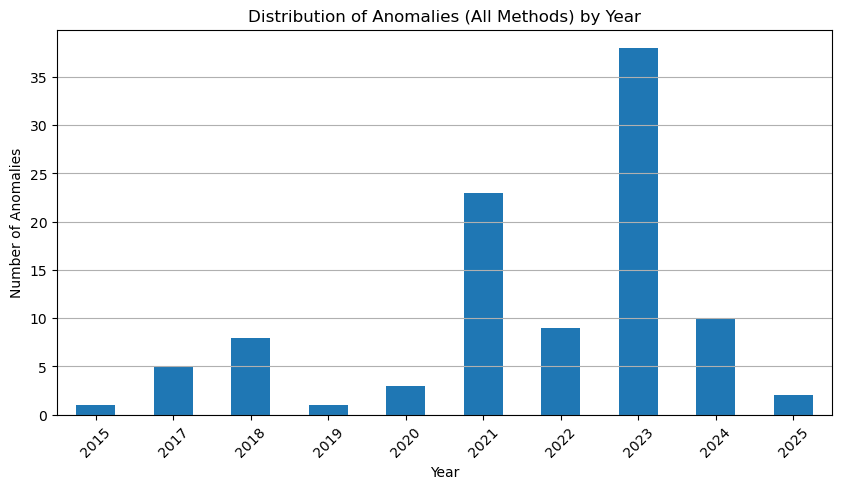

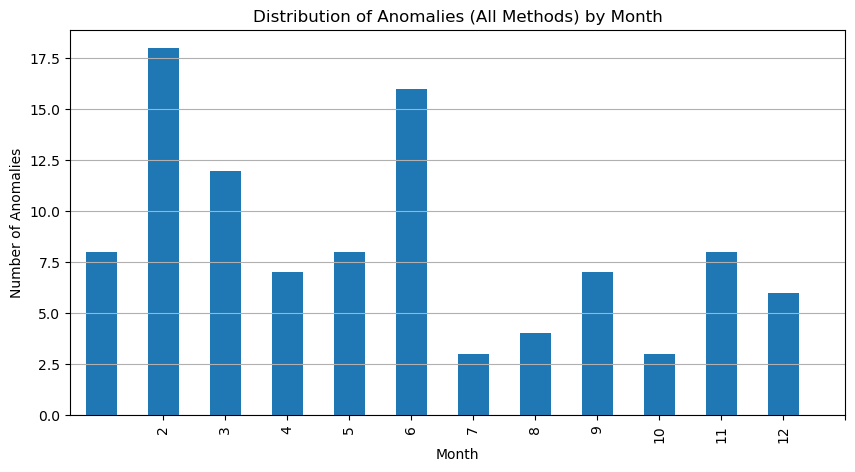


Statistical Summary of Anomalous Periods (All Methods):
             Close        Volume      Return
count   100.000000  1.000000e+02  100.000000
mean   1777.855865  2.310223e+07    0.004720
std    1070.057329  2.631145e+07    0.103219
min      49.395317  2.798065e+06   -0.281970
25%    1243.647644  8.492022e+06   -0.053650
50%    1676.331177  1.513673e+07    0.002323
75%    2459.657288  2.312221e+07    0.068067
max    3896.479492  1.701502e+08    0.273680


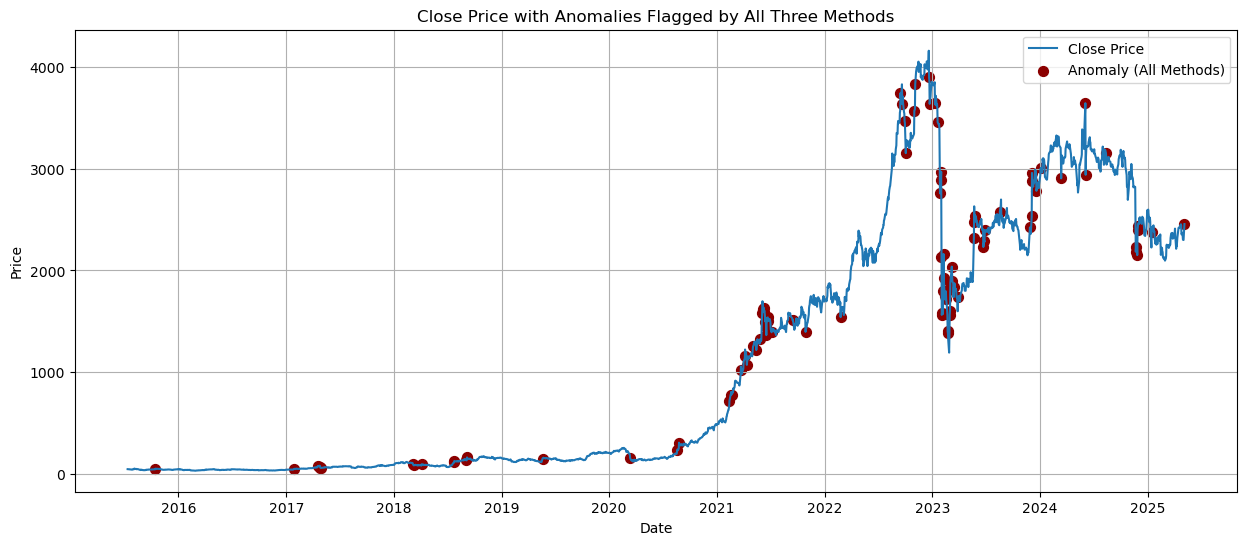

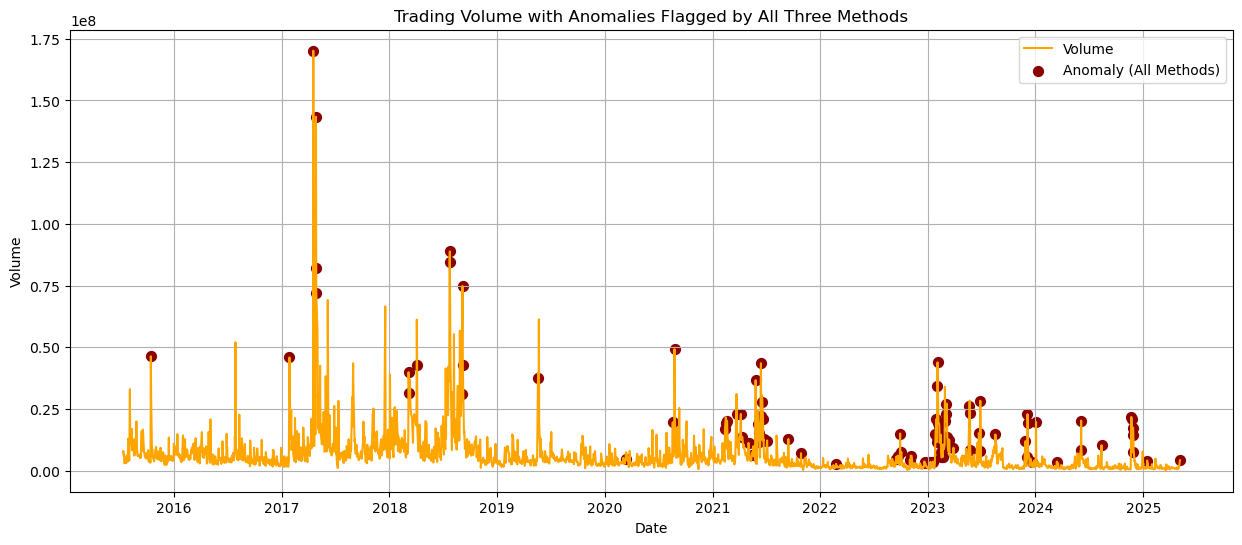

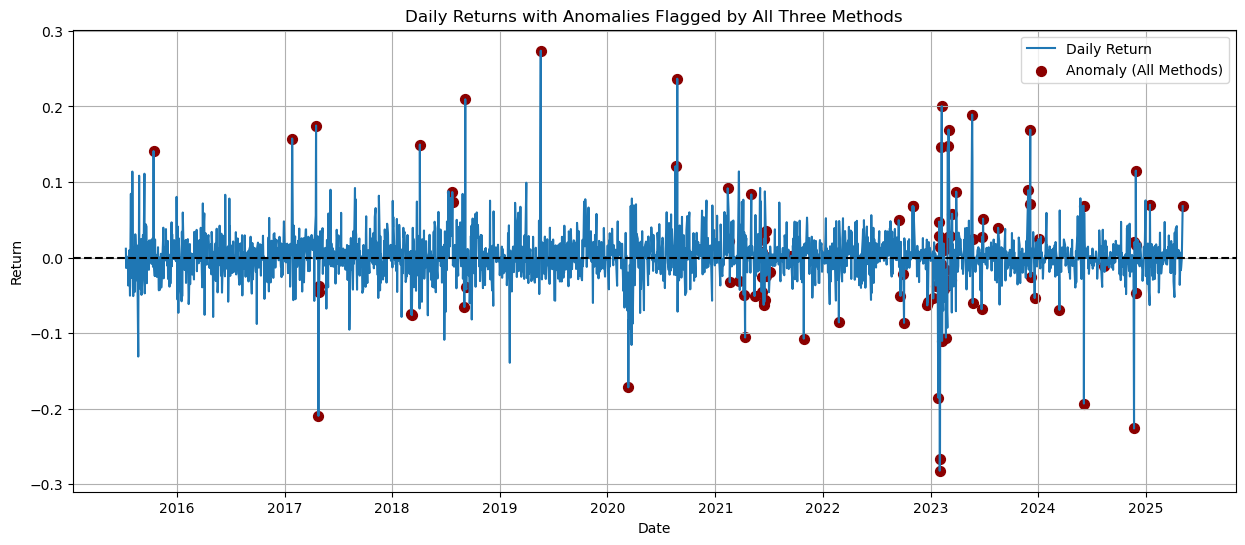


Consider the dates of these anomalies (index of combined_anomalies_all_df):
['2015-10-15', '2017-01-27', '2017-04-18', '2017-04-26', '2017-04-27', '2017-04-28', '2018-03-07', '2018-03-09', '2018-04-05', '2018-07-24', '2018-07-25', '2018-09-03', '2018-09-06', '2018-09-07', '2019-05-20', '2020-03-12', '2020-08-19', '2020-08-25', '2021-02-12', '2021-02-16', '2021-02-19', '2021-03-24', '2021-04-07', '2021-04-12', '2021-05-03', '2021-05-14', '2021-05-27', '2021-06-03', '2021-06-07', '2021-06-08', '2021-06-09', '2021-06-14', '2021-06-15', '2021-06-16', '2021-06-17', '2021-06-21', '2021-06-22', '2021-06-23', '2021-07-05', '2021-09-15', '2021-10-28', '2022-02-24', '2022-09-15', '2022-09-21', '2022-09-29', '2022-10-03', '2022-11-01', '2022-11-04', '2022-12-21', '2022-12-23', '2023-01-10', '2023-01-19', '2023-01-27', '2023-01-30', '2023-01-31', '2023-02-01', '2023-02-02', '2023-02-03', '2023-02-06', '2023-02-07', '2023-02-08', '2023-02-09', '2023-02-14', '2023-02-15', '2023-02-16', '2023-02-17'

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have already run the previous code and have the 'df' DataFrame
# with the anomaly detection columns and the 'combined_anomalies_all_df' DataFrame.

# ----------------------------------------------------------------------
# Analysis of Combined Anomalies (Flagged by All Three Methods)
# ----------------------------------------------------------------------

print("\n--- Analysis of Anomalies Flagged by All Three Methods ---")
print(f"Number of Anomalies Flagged by All Three Methods: {len(combined_anomalies_all_df)}")

if not combined_anomalies_all_df.empty:
    print("\nFirst few rows of anomalies flagged by all three methods:")
    print(combined_anomalies_all_df.head())

    # 1. Time Distribution of Anomalies
    plt.figure(figsize=(10, 5))
    combined_anomalies_all_df.index.name = 'Date'  # Ensure index has a name for plotting
    combined_anomalies_all_df.groupby(combined_anomalies_all_df.index.year).size().plot(kind='bar')
    plt.title('Distribution of Anomalies (All Methods) by Year')
    plt.xlabel('Year')
    plt.ylabel('Number of Anomalies')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.show()

    plt.figure(figsize=(10, 5))
    combined_anomalies_all_df.groupby(combined_anomalies_all_df.index.month).size().plot(kind='bar')
    plt.title('Distribution of Anomalies (All Methods) by Month')
    plt.xlabel('Month')
    plt.ylabel('Number of Anomalies')
    plt.xticks(range(1, 13))
    plt.grid(axis='y')
    plt.show()

    # 2. Statistical Summary of Anomalous Periods
    print("\nStatistical Summary of Anomalous Periods (All Methods):")
    print(combined_anomalies_all_df[['Close', 'Volume', 'Return']].describe())

    # 3. Examining Price and Volume Behavior During Anomalies
    plt.figure(figsize=(15, 6))
    plt.plot(df['Close'], label='Close Price')
    plt.scatter(combined_anomalies_all_df.index, combined_anomalies_all_df['Close'], color='darkred', s=50, label='Anomaly (All Methods)')
    plt.title('Close Price with Anomalies Flagged by All Three Methods')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(15, 6))
    plt.plot(df['Volume'], color='orange', label='Volume')
    plt.scatter(combined_anomalies_all_df.index, combined_anomalies_all_df['Volume'], color='darkred', s=50, label='Anomaly (All Methods)')
    plt.title('Trading Volume with Anomalies Flagged by All Three Methods')
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 4. Analyzing Returns During Anomalies
    plt.figure(figsize=(15, 6))
    plt.plot(df['Return'], label='Daily Return')
    plt.scatter(combined_anomalies_all_df.index, combined_anomalies_all_df['Return'], color='darkred', s=50, label='Anomaly (All Methods)')
    plt.title('Daily Returns with Anomalies Flagged by All Three Methods')
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.legend()
    plt.grid(True)
    plt.axhline(y=0, color='black', linestyle='--')
    plt.show()

    # 5. Further Investigation: Correlating with External Events
    print("\nConsider the dates of these anomalies (index of combined_anomalies_all_df):")
    print(combined_anomalies_all_df.index.strftime('%Y-%m-%d').tolist())
    print("\nYou should now research news and events related to Adani stocks around these dates to understand the potential causes of these highly consistent anomalies.")

else:
    print("\nNo anomalies were flagged by all three methods.")